In [1]:
import os
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch import optim
import torchvision.utils as torch_utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generator and Discriminator Utilities
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)
    

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x
    
def target_to_oh_shoe(target):
    NUM_CLASS = 10
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot


# Train and Eval utilities
def generate_examples(gen, steps, z_dim, n=100):
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, z_dim).to(device)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

  
def gradient_penalty(critic, labels, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def get_loader(image_size):
    transform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(channels_img)],
            [0.5 for _ in range(channels_img)],
         )
        ]
    )
    batch_size = batch_sizes[int(math.log2(image_size/4))]
    dataset = datasets.ImageFolder(root=dataset_dir, transform=transform, target_transform = target_to_oh_shoe)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

def check_loader():
    loader, _ = get_loader(128)
    cloth, _  = next(iter(loader))
    _, ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1

In [2]:
image_factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Same as ProGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3, classes=10):
        super(Discriminator, self).__init__()
        self.embedding = nn.Linear(classes, 1*4*4)

        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(image_factors) - 1, 0, -1):
            conv_in = int(in_channels * image_factors[i])
            conv_out = int(in_channels * image_factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, label, alpha, steps):
        label_embedding = self.embedding(label).view(-1, 1, 4, 4)
        factor = x.shape[-1]//label_embedding.shape[-1]
        a, b, c, d = label_embedding.shape
        label_embedding = label_embedding.view(a, b, c, 1, d, 1)
        label_embedding = label_embedding.repeat(1, 1, 1, factor, 1, factor)
        label_embedding = label_embedding.reshape(a, b, x.shape[-1], x.shape[-1])
#         x = torch.concat((x, label_embedding), dim=1)
        x = x + label_embedding
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [3]:
image_factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]

# Normalization on every element of input vector
# Adapted from StyleGAN original Implementation
class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)
    
# Implementing the Noise Mapping Network
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features,
    ):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale = (2 / in_features)**0.5
        self.bias = self.linear.bias
        self.linear.bias = None

        # initialize linear layer
        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.linear(x * self.scale) + self.bias
    

class NoiseMappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.noise_mapping = nn.Sequential(
            PixelNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self, x):
        return self.noise_mapping(x)
    

# Adaptive Instance Normalization (AdaIn)
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale = WSLinear(w_dim, channels)
        self.style_bias = WSLinear(w_dim, channels)

    def forward(self, x, w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias
    

class NoiseInjectNet(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device)
        return x + self.weight * noise

class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = NoiseInjectNet(out_channels)
        self.inject_noise2 = NoiseInjectNet(out_channels)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)

    def forward(self, x, w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3, classes=10):
        super(Generator, self).__init__()
        self.embedding = nn.Linear(classes, 4*4)

        self.starting_constant = nn.Parameter(torch.ones((1, in_channels, 4, 4)))
        self.map = NoiseMappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = NoiseInjectNet(in_channels)
        self.initial_noise2 = NoiseInjectNet(in_channels)
        self.initial_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(len(image_factors) - 1):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * image_factors[i])
            conv_out_c = int(in_channels * image_factors[i + 1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, noise, label, alpha, steps):
#         print(label.shape)
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_constant), w)
        label_embedding = self.embedding(label).view(-1, 1, 4, 4)
        factor = x.shape[-1]//label_embedding.shape[-1]
        a, b, c, d = label_embedding.shape
        label_embedding = label_embedding.view(a, b, c, 1, d, 1)
        label_embedding = label_embedding.repeat(1, 1, 1, factor, 1, factor)
        label_embedding = label_embedding.reshape(a, b, x.shape[-1], x.shape[-1])
#         print(x.shape, label_embedding.shape)
#         x = torch.concat((x, label_embedding), dim = 1)
        x = x + label_embedding
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="bilinear")
            out = self.prog_blocks[step](upscaled, w)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)



Curent image size: 4


  1%|          | 1/83 [00:03<04:07,  3.01s/it, disc_loss=-0.14, grad_penalty=0.0676]

[0/5][0/83]	Loss_D: -0.1399165689945221	Loss_G: 2.8845038414001465


 61%|██████▏   | 51/83 [01:17<00:48,  1.51s/it, disc_loss=-69.3, grad_penalty=2.89]

[0/5][50/83]	Loss_D: -69.2576904296875	Loss_G: 109.96463012695312


  1%|          | 1/83 [00:00<00:53,  1.52it/s, disc_loss=-62.3, grad_penalty=2.33]

[1/5][0/83]	Loss_D: -62.32175827026367	Loss_G: 91.36253356933594


 61%|██████▏   | 51/83 [00:33<00:21,  1.48it/s, disc_loss=-12.5, grad_penalty=1.08]

[1/5][50/83]	Loss_D: -12.482245445251465	Loss_G: 25.108741760253906


  1%|          | 1/83 [00:00<00:55,  1.48it/s, disc_loss=-44.3, grad_penalty=0.821]

[2/5][0/83]	Loss_D: -44.267578125	Loss_G: 55.9426155090332


 61%|██████▏   | 51/83 [00:34<00:21,  1.50it/s, disc_loss=-14.3, grad_penalty=0.565]

[2/5][50/83]	Loss_D: -14.30292797088623	Loss_G: 20.248239517211914


  1%|          | 1/83 [00:00<00:54,  1.51it/s, disc_loss=-46.3, grad_penalty=0.544]

[3/5][0/83]	Loss_D: -46.330875396728516	Loss_G: 54.92543029785156


 61%|██████▏   | 51/83 [00:33<00:21,  1.46it/s, disc_loss=-13.6, grad_penalty=0.479]

[3/5][50/83]	Loss_D: -13.592843055725098	Loss_G: 17.614442825317383


  1%|          | 1/83 [00:00<00:53,  1.55it/s, disc_loss=-44.2, grad_penalty=0.457]

[4/5][0/83]	Loss_D: -44.185977935791016	Loss_G: 53.89088821411133


 61%|██████▏   | 51/83 [00:33<00:22,  1.45it/s, disc_loss=-17.2, grad_penalty=0.554]

[4/5][50/83]	Loss_D: -17.18231201171875	Loss_G: 22.08635711669922


100%|██████████| 83/83 [00:54<00:00,  1.53it/s, disc_loss=-14.8, grad_penalty=0.551]


Curent image size: 8


  1%|          | 1/165 [00:00<01:38,  1.67it/s, disc_loss=-8.14, grad_penalty=0.0251]

[0/5][0/165]	Loss_D: -8.136428833007812	Loss_G: 8.547213554382324


 31%|███       | 51/165 [00:29<01:04,  1.76it/s, disc_loss=-3.41, grad_penalty=0.0561]

[0/5][50/165]	Loss_D: -3.4080257415771484	Loss_G: 4.565030097961426


 61%|██████    | 101/165 [00:59<00:37,  1.71it/s, disc_loss=-3.13, grad_penalty=0.0421]

[0/5][100/165]	Loss_D: -3.1273763179779053	Loss_G: 4.718770980834961


 92%|█████████▏| 151/165 [01:28<00:08,  1.70it/s, disc_loss=-3.07, grad_penalty=0.0674]

[0/5][150/165]	Loss_D: -3.0673344135284424	Loss_G: 3.9579343795776367


  1%|          | 1/165 [00:00<01:39,  1.65it/s, disc_loss=-2.99, grad_penalty=0.0284]

[1/5][0/165]	Loss_D: -2.990499496459961	Loss_G: 4.147791385650635


 31%|███       | 51/165 [00:29<01:06,  1.72it/s, disc_loss=-2.79, grad_penalty=0.047]

[1/5][50/165]	Loss_D: -2.7873358726501465	Loss_G: 3.884664535522461


 61%|██████    | 101/165 [00:58<00:37,  1.71it/s, disc_loss=-2.52, grad_penalty=0.0165]

[1/5][100/165]	Loss_D: -2.518185615539551	Loss_G: 4.759736061096191


 92%|█████████▏| 151/165 [01:28<00:08,  1.72it/s, disc_loss=-2.98, grad_penalty=0.0348]

[1/5][150/165]	Loss_D: -2.981520891189575	Loss_G: 5.361316204071045


  1%|          | 1/165 [00:00<01:33,  1.75it/s, disc_loss=-2.59, grad_penalty=0.0245]

[2/5][0/165]	Loss_D: -2.5933942794799805	Loss_G: 7.65777063369751


 31%|███       | 51/165 [00:30<01:09,  1.64it/s, disc_loss=-2.5, grad_penalty=0.0143]

[2/5][50/165]	Loss_D: -2.4973621368408203	Loss_G: 5.362349987030029


 61%|██████    | 101/165 [00:59<00:37,  1.69it/s, disc_loss=-3, grad_penalty=0.0278]

[2/5][100/165]	Loss_D: -2.997795820236206	Loss_G: 4.965590000152588


 92%|█████████▏| 151/165 [01:29<00:08,  1.64it/s, disc_loss=-3.28, grad_penalty=0.0627]

[2/5][150/165]	Loss_D: -3.278723955154419	Loss_G: 4.1753950119018555


  1%|          | 1/165 [00:00<01:38,  1.67it/s, disc_loss=-3.07, grad_penalty=0.0192]

[3/5][0/165]	Loss_D: -3.067333698272705	Loss_G: 7.125545024871826


 31%|███       | 51/165 [00:29<01:05,  1.74it/s, disc_loss=-2.51, grad_penalty=0.0504]

[3/5][50/165]	Loss_D: -2.5101330280303955	Loss_G: 2.4256558418273926


 61%|██████    | 101/165 [00:59<00:38,  1.66it/s, disc_loss=-1.97, grad_penalty=0.0197]

[3/5][100/165]	Loss_D: -1.9686692953109741	Loss_G: 3.2664432525634766


 92%|█████████▏| 151/165 [01:28<00:08,  1.72it/s, disc_loss=-2.81, grad_penalty=0.0162]

[3/5][150/165]	Loss_D: -2.809880495071411	Loss_G: 6.001030921936035


  1%|          | 1/165 [00:00<01:33,  1.76it/s, disc_loss=-2.01, grad_penalty=0.0499]

[4/5][0/165]	Loss_D: -2.0106279850006104	Loss_G: 1.5008400678634644


 31%|███       | 51/165 [00:30<01:06,  1.72it/s, disc_loss=-2.19, grad_penalty=0.0429]

[4/5][50/165]	Loss_D: -2.1868844032287598	Loss_G: 2.3148393630981445


 61%|██████    | 101/165 [00:59<00:38,  1.67it/s, disc_loss=-1.58, grad_penalty=0.0418]

[4/5][100/165]	Loss_D: -1.5788776874542236	Loss_G: 1.3207519054412842


 92%|█████████▏| 151/165 [01:30<00:08,  1.63it/s, disc_loss=-2.51, grad_penalty=0.0122]

[4/5][150/165]	Loss_D: -2.513936996459961	Loss_G: 5.385124206542969


100%|██████████| 165/165 [01:38<00:00,  1.67it/s, disc_loss=-2.57, grad_penalty=0.0362]


Curent image size: 16


  0%|          | 1/329 [00:00<04:06,  1.33it/s, disc_loss=0.55, grad_penalty=0.261]

[0/5][0/329]	Loss_D: 0.5503354668617249	Loss_G: 7.506278991699219


 16%|█▌        | 51/329 [00:38<03:28,  1.33it/s, disc_loss=-4.98, grad_penalty=0.0289]

[0/5][50/329]	Loss_D: -4.975086212158203	Loss_G: 8.567410469055176


 31%|███       | 101/329 [01:15<02:44,  1.39it/s, disc_loss=-4, grad_penalty=0.0641]

[0/5][100/329]	Loss_D: -3.9953713417053223	Loss_G: 5.723597526550293


 46%|████▌     | 151/329 [01:51<02:08,  1.38it/s, disc_loss=-3.72, grad_penalty=0.0192]

[0/5][150/329]	Loss_D: -3.722795248031616	Loss_G: 7.488314628601074


 61%|██████    | 201/329 [02:28<01:34,  1.36it/s, disc_loss=-3.55, grad_penalty=0.0291]

[0/5][200/329]	Loss_D: -3.54965877532959	Loss_G: 5.498006820678711


 76%|███████▋  | 251/329 [03:04<00:56,  1.39it/s, disc_loss=-2.36, grad_penalty=0.0395]

[0/5][250/329]	Loss_D: -2.3610501289367676	Loss_G: 3.706728458404541


 91%|█████████▏| 301/329 [03:41<00:20,  1.37it/s, disc_loss=-2.59, grad_penalty=0.0172]

[0/5][300/329]	Loss_D: -2.590608596801758	Loss_G: 8.116747856140137


  0%|          | 1/329 [00:00<03:59,  1.37it/s, disc_loss=-3.3, grad_penalty=0.0334]

[1/5][0/329]	Loss_D: -3.304828643798828	Loss_G: 5.559389591217041


 16%|█▌        | 51/329 [00:37<03:22,  1.37it/s, disc_loss=-3.6, grad_penalty=0.0396]

[1/5][50/329]	Loss_D: -3.5982859134674072	Loss_G: 5.079610824584961


 31%|███       | 101/329 [01:13<02:44,  1.38it/s, disc_loss=-2.79, grad_penalty=0.0785]

[1/5][100/329]	Loss_D: -2.789401054382324	Loss_G: 1.2952710390090942


 46%|████▌     | 151/329 [01:50<02:09,  1.38it/s, disc_loss=-2.95, grad_penalty=0.0652]

[1/5][150/329]	Loss_D: -2.9510600566864014	Loss_G: 1.101183533668518


 61%|██████    | 201/329 [02:26<01:34,  1.35it/s, disc_loss=-3.36, grad_penalty=0.0777]

[1/5][200/329]	Loss_D: -3.364341974258423	Loss_G: 0.47656774520874023


 76%|███████▋  | 251/329 [03:03<00:57,  1.36it/s, disc_loss=-2.77, grad_penalty=0.0225]

[1/5][250/329]	Loss_D: -2.7716825008392334	Loss_G: 7.102444648742676


 91%|█████████▏| 301/329 [03:41<00:20,  1.35it/s, disc_loss=-3.43, grad_penalty=0.0379]

[1/5][300/329]	Loss_D: -3.425302028656006	Loss_G: 8.344606399536133


  0%|          | 1/329 [00:00<03:58,  1.37it/s, disc_loss=-2.38, grad_penalty=0.0119]

[2/5][0/329]	Loss_D: -2.3838658332824707	Loss_G: 7.739593505859375


 16%|█▌        | 51/329 [00:37<03:27,  1.34it/s, disc_loss=-2.37, grad_penalty=0.0209]

[2/5][50/329]	Loss_D: -2.370419502258301	Loss_G: 6.0700297355651855


 31%|███       | 101/329 [01:13<02:45,  1.37it/s, disc_loss=-2.73, grad_penalty=0.0218]

[2/5][100/329]	Loss_D: -2.733919382095337	Loss_G: 7.121811866760254


 46%|████▌     | 151/329 [01:50<02:10,  1.37it/s, disc_loss=-3.99, grad_penalty=0.0336]

[2/5][150/329]	Loss_D: -3.9880406856536865	Loss_G: 9.255855560302734


 61%|██████    | 201/329 [02:27<01:33,  1.36it/s, disc_loss=-2.85, grad_penalty=0.0761]

[2/5][200/329]	Loss_D: -2.8506369590759277	Loss_G: 3.40151309967041


 76%|███████▋  | 251/329 [03:04<00:56,  1.38it/s, disc_loss=-2.92, grad_penalty=0.0308]

[2/5][250/329]	Loss_D: -2.9213004112243652	Loss_G: 6.271657943725586


 91%|█████████▏| 301/329 [03:40<00:20,  1.36it/s, disc_loss=-2.76, grad_penalty=0.0469]

[2/5][300/329]	Loss_D: -2.7629928588867188	Loss_G: 5.768711566925049


  0%|          | 1/329 [00:00<04:01,  1.36it/s, disc_loss=-2.67, grad_penalty=0.0172]

[3/5][0/329]	Loss_D: -2.6680684089660645	Loss_G: 9.87090015411377


 16%|█▌        | 51/329 [00:37<03:24,  1.36it/s, disc_loss=-2.42, grad_penalty=0.0422]

[3/5][50/329]	Loss_D: -2.4208381175994873	Loss_G: 2.300053358078003


 31%|███       | 101/329 [01:14<02:48,  1.35it/s, disc_loss=-2.27, grad_penalty=0.017]

[3/5][100/329]	Loss_D: -2.272986650466919	Loss_G: 4.6488356590271


 46%|████▌     | 151/329 [01:51<02:11,  1.36it/s, disc_loss=-2.65, grad_penalty=0.0272]

[3/5][150/329]	Loss_D: -2.6499955654144287	Loss_G: 3.889798164367676


 61%|██████    | 201/329 [02:28<01:35,  1.34it/s, disc_loss=-2.55, grad_penalty=0.0278]

[3/5][200/329]	Loss_D: -2.5464093685150146	Loss_G: 4.833525657653809


 76%|███████▋  | 251/329 [03:05<00:56,  1.37it/s, disc_loss=-2.15, grad_penalty=0.0186]

[3/5][250/329]	Loss_D: -2.1474833488464355	Loss_G: 3.9400596618652344


 91%|█████████▏| 301/329 [03:41<00:20,  1.37it/s, disc_loss=-3.3, grad_penalty=0.0378]

[3/5][300/329]	Loss_D: -3.3048336505889893	Loss_G: 5.121185302734375


  0%|          | 1/329 [00:00<03:57,  1.38it/s, disc_loss=-1.22, grad_penalty=0.0155]

[4/5][0/329]	Loss_D: -1.216317892074585	Loss_G: 6.698052406311035


 16%|█▌        | 51/329 [00:37<03:24,  1.36it/s, disc_loss=-2.2, grad_penalty=0.0626]

[4/5][50/329]	Loss_D: -2.200918197631836	Loss_G: 0.08952251076698303


 31%|███       | 101/329 [01:13<02:47,  1.37it/s, disc_loss=-4.09, grad_penalty=0.0712]

[4/5][100/329]	Loss_D: -4.093230724334717	Loss_G: 3.9524331092834473


 46%|████▌     | 151/329 [01:51<02:10,  1.37it/s, disc_loss=-1.35, grad_penalty=0.0191]

[4/5][150/329]	Loss_D: -1.3454313278198242	Loss_G: 2.3684134483337402


 61%|██████    | 201/329 [02:27<01:35,  1.34it/s, disc_loss=-1.27, grad_penalty=0.0446]

[4/5][200/329]	Loss_D: -1.2721588611602783	Loss_G: 2.2706403732299805


 76%|███████▋  | 251/329 [03:04<00:57,  1.37it/s, disc_loss=-1.4, grad_penalty=0.0189]

[4/5][250/329]	Loss_D: -1.396483302116394	Loss_G: 1.6284234523773193


 91%|█████████▏| 301/329 [03:41<00:20,  1.35it/s, disc_loss=-3, grad_penalty=0.0218]

[4/5][300/329]	Loss_D: -2.9956650733947754	Loss_G: 6.545117378234863


100%|██████████| 329/329 [04:01<00:00,  1.36it/s, disc_loss=-2.02, grad_penalty=0.0517]


Curent image size: 32


  0%|          | 1/657 [00:01<12:14,  1.12s/it, disc_loss=0.892, grad_penalty=0.225]

[0/5][0/657]	Loss_D: 0.8923386335372925	Loss_G: 4.092732906341553


  8%|▊         | 51/657 [00:56<11:13,  1.11s/it, disc_loss=-4.63, grad_penalty=0.0708]

[0/5][50/657]	Loss_D: -4.632926940917969	Loss_G: 6.566291809082031


 15%|█▌        | 101/657 [01:52<10:15,  1.11s/it, disc_loss=-3.87, grad_penalty=0.0626]

[0/5][100/657]	Loss_D: -3.8697078227996826	Loss_G: 4.1482086181640625


 23%|██▎       | 151/657 [02:48<09:21,  1.11s/it, disc_loss=-4.61, grad_penalty=0.0739]

[0/5][150/657]	Loss_D: -4.6147637367248535	Loss_G: 4.386575698852539


 31%|███       | 201/657 [03:44<08:25,  1.11s/it, disc_loss=-2.69, grad_penalty=0.0484]

[0/5][200/657]	Loss_D: -2.6940009593963623	Loss_G: 3.6913623809814453


 38%|███▊      | 251/657 [04:39<07:29,  1.11s/it, disc_loss=-3.36, grad_penalty=0.0462]

[0/5][250/657]	Loss_D: -3.3591315746307373	Loss_G: 3.670105218887329


 46%|████▌     | 301/657 [05:35<06:37,  1.12s/it, disc_loss=-1.45, grad_penalty=0.0614]

[0/5][300/657]	Loss_D: -1.4481831789016724	Loss_G: 2.7185816764831543


 53%|█████▎    | 351/657 [06:31<05:40,  1.11s/it, disc_loss=-3.89, grad_penalty=0.0455]

[0/5][350/657]	Loss_D: -3.8934671878814697	Loss_G: 4.715343475341797


 61%|██████    | 401/657 [07:27<04:45,  1.12s/it, disc_loss=-1.86, grad_penalty=0.133]

[0/5][400/657]	Loss_D: -1.8589195013046265	Loss_G: -3.1934242248535156


 69%|██████▊   | 451/657 [08:22<03:51,  1.13s/it, disc_loss=-4.7, grad_penalty=0.0968]

[0/5][450/657]	Loss_D: -4.69870662689209	Loss_G: 5.772359848022461


 76%|███████▋  | 501/657 [09:18<02:54,  1.12s/it, disc_loss=-3.66, grad_penalty=0.0196]

[0/5][500/657]	Loss_D: -3.6639394760131836	Loss_G: 10.977951049804688


 84%|████████▍ | 551/657 [10:15<01:59,  1.13s/it, disc_loss=-2.28, grad_penalty=0.0285]

[0/5][550/657]	Loss_D: -2.283114433288574	Loss_G: 5.766368865966797


 91%|█████████▏| 601/657 [11:11<01:03,  1.14s/it, disc_loss=-3.52, grad_penalty=0.0627]

[0/5][600/657]	Loss_D: -3.523378372192383	Loss_G: 3.3309848308563232


 99%|█████████▉| 651/657 [12:09<00:06,  1.14s/it, disc_loss=-1.97, grad_penalty=0.0228]

[0/5][650/657]	Loss_D: -1.970436930656433	Loss_G: 3.6637606620788574


  0%|          | 1/657 [00:01<12:09,  1.11s/it, disc_loss=-4.49, grad_penalty=0.0627]

[1/5][0/657]	Loss_D: -4.491513252258301	Loss_G: 7.718142986297607


  8%|▊         | 51/657 [00:57<11:16,  1.12s/it, disc_loss=-2.83, grad_penalty=0.0478]

[1/5][50/657]	Loss_D: -2.825986385345459	Loss_G: 8.903342247009277


 15%|█▌        | 101/657 [01:53<10:21,  1.12s/it, disc_loss=-1.97, grad_penalty=0.0239]

[1/5][100/657]	Loss_D: -1.9688359498977661	Loss_G: 1.8629249334335327


 23%|██▎       | 151/657 [02:49<09:29,  1.13s/it, disc_loss=-3.19, grad_penalty=0.066]

[1/5][150/657]	Loss_D: -3.1866390705108643	Loss_G: 1.9275368452072144


 31%|███       | 201/657 [03:46<08:35,  1.13s/it, disc_loss=-2.18, grad_penalty=0.117]

[1/5][200/657]	Loss_D: -2.183781623840332	Loss_G: 2.845728874206543


 38%|███▊      | 251/657 [04:42<07:37,  1.13s/it, disc_loss=-2.39, grad_penalty=0.0369]

[1/5][250/657]	Loss_D: -2.3871586322784424	Loss_G: 5.971926689147949


 46%|████▌     | 301/657 [05:39<06:43,  1.13s/it, disc_loss=-5.2, grad_penalty=0.0674]

[1/5][300/657]	Loss_D: -5.2011189460754395	Loss_G: 5.7805609703063965


 53%|█████▎    | 351/657 [06:36<05:47,  1.14s/it, disc_loss=-4.35, grad_penalty=0.097]

[1/5][350/657]	Loss_D: -4.3493194580078125	Loss_G: 4.980423927307129


 61%|██████    | 401/657 [07:34<04:52,  1.14s/it, disc_loss=-1.87, grad_penalty=0.0234]

[1/5][400/657]	Loss_D: -1.874881386756897	Loss_G: 5.309877395629883


 69%|██████▊   | 451/657 [08:31<03:55,  1.15s/it, disc_loss=-2.57, grad_penalty=0.05]

[1/5][450/657]	Loss_D: -2.569497585296631	Loss_G: 4.718005180358887


 76%|███████▋  | 501/657 [09:29<02:59,  1.15s/it, disc_loss=-2.08, grad_penalty=0.0148]

[1/5][500/657]	Loss_D: -2.084160089492798	Loss_G: 3.0486412048339844


 84%|████████▍ | 551/657 [10:27<02:02,  1.16s/it, disc_loss=-4.47, grad_penalty=0.0394]

[1/5][550/657]	Loss_D: -4.47437858581543	Loss_G: 8.399968147277832


 91%|█████████▏| 601/657 [11:25<01:04,  1.15s/it, disc_loss=-2.34, grad_penalty=0.0744]

[1/5][600/657]	Loss_D: -2.3352954387664795	Loss_G: -0.48879894614219666


 99%|█████████▉| 651/657 [12:23<00:06,  1.16s/it, disc_loss=-2.66, grad_penalty=0.0219]

[1/5][650/657]	Loss_D: -2.6627442836761475	Loss_G: 4.003164291381836


  0%|          | 1/657 [00:01<12:13,  1.12s/it, disc_loss=-1.44, grad_penalty=0.0159]

[2/5][0/657]	Loss_D: -1.4383646249771118	Loss_G: 2.5494918823242188


  8%|▊         | 51/657 [00:57<11:18,  1.12s/it, disc_loss=-3.78, grad_penalty=0.108]

[2/5][50/657]	Loss_D: -3.7750589847564697	Loss_G: 3.23333477973938


 15%|█▌        | 101/657 [01:53<10:22,  1.12s/it, disc_loss=-1.51, grad_penalty=0.0231]

[2/5][100/657]	Loss_D: -1.5132472515106201	Loss_G: 6.902729034423828


 23%|██▎       | 151/657 [02:50<09:30,  1.13s/it, disc_loss=-2.5, grad_penalty=0.0525]

[2/5][150/657]	Loss_D: -2.5040934085845947	Loss_G: 2.485631227493286


 31%|███       | 201/657 [03:46<08:34,  1.13s/it, disc_loss=-2.54, grad_penalty=0.049]

[2/5][200/657]	Loss_D: -2.542914628982544	Loss_G: 0.6965547800064087


 38%|███▊      | 251/657 [04:43<07:40,  1.14s/it, disc_loss=-2.35, grad_penalty=0.0152]

[2/5][250/657]	Loss_D: -2.345109224319458	Loss_G: 3.681934356689453


 46%|████▌     | 301/657 [05:40<06:42,  1.13s/it, disc_loss=-5.27, grad_penalty=0.118]

[2/5][300/657]	Loss_D: -5.265710353851318	Loss_G: 0.6665864586830139


 53%|█████▎    | 351/657 [06:37<05:49,  1.14s/it, disc_loss=-3.76, grad_penalty=0.0993]

[2/5][350/657]	Loss_D: -3.7558441162109375	Loss_G: 2.3755476474761963


 61%|██████    | 401/657 [07:34<04:55,  1.15s/it, disc_loss=-1.56, grad_penalty=0.0196]

[2/5][400/657]	Loss_D: -1.5605800151824951	Loss_G: 2.9326725006103516


 69%|██████▊   | 451/657 [08:31<03:58,  1.16s/it, disc_loss=-3.4, grad_penalty=0.0314]

[2/5][450/657]	Loss_D: -3.395547389984131	Loss_G: 4.797965049743652


 76%|███████▋  | 501/657 [09:29<02:59,  1.15s/it, disc_loss=-1.65, grad_penalty=0.0232]

[2/5][500/657]	Loss_D: -1.6501262187957764	Loss_G: 1.7418229579925537


 84%|████████▍ | 551/657 [10:27<02:02,  1.16s/it, disc_loss=-2.49, grad_penalty=0.0847]

[2/5][550/657]	Loss_D: -2.488321304321289	Loss_G: 3.8994011878967285


 91%|█████████▏| 601/657 [11:25<01:04,  1.15s/it, disc_loss=-3.2, grad_penalty=0.0505]

[2/5][600/657]	Loss_D: -3.1972157955169678	Loss_G: 3.211590051651001


 99%|█████████▉| 651/657 [12:23<00:06,  1.16s/it, disc_loss=-3.31, grad_penalty=0.047]

[2/5][650/657]	Loss_D: -3.3057944774627686	Loss_G: 3.94626522064209


  0%|          | 1/657 [00:01<12:20,  1.13s/it, disc_loss=-3.25, grad_penalty=0.144]

[3/5][0/657]	Loss_D: -3.2537031173706055	Loss_G: -2.4059648513793945


  8%|▊         | 51/657 [00:57<11:22,  1.13s/it, disc_loss=-2.49, grad_penalty=0.0547]

[3/5][50/657]	Loss_D: -2.486983299255371	Loss_G: 0.37726253271102905


 15%|█▌        | 101/657 [01:53<10:27,  1.13s/it, disc_loss=-2.51, grad_penalty=0.031]

[3/5][100/657]	Loss_D: -2.510018825531006	Loss_G: 1.6342196464538574


 23%|██▎       | 151/657 [02:50<09:31,  1.13s/it, disc_loss=-3.32, grad_penalty=0.0653]

[3/5][150/657]	Loss_D: -3.3197433948516846	Loss_G: 3.0152745246887207


 31%|███       | 201/657 [03:46<08:38,  1.14s/it, disc_loss=-2.52, grad_penalty=0.0226]

[3/5][200/657]	Loss_D: -2.5166850090026855	Loss_G: 4.070459842681885


 38%|███▊      | 251/657 [04:43<07:40,  1.13s/it, disc_loss=-2.05, grad_penalty=0.0592]

[3/5][250/657]	Loss_D: -2.0480406284332275	Loss_G: 3.722705841064453


 46%|████▌     | 301/657 [05:40<06:46,  1.14s/it, disc_loss=-2.55, grad_penalty=0.0245]

[3/5][300/657]	Loss_D: -2.5530266761779785	Loss_G: 2.359067440032959


 53%|█████▎    | 351/657 [06:37<05:50,  1.15s/it, disc_loss=-1.12, grad_penalty=0.0187]

[3/5][350/657]	Loss_D: -1.1182773113250732	Loss_G: -0.13071691989898682


 61%|██████    | 401/657 [07:35<04:54,  1.15s/it, disc_loss=-3.29, grad_penalty=0.0852]

[3/5][400/657]	Loss_D: -3.291703701019287	Loss_G: 0.9369231462478638


 69%|██████▊   | 451/657 [08:33<03:57,  1.15s/it, disc_loss=-4.01, grad_penalty=0.0251]

[3/5][450/657]	Loss_D: -4.008098602294922	Loss_G: 8.946870803833008


 76%|███████▋  | 501/657 [09:30<02:59,  1.15s/it, disc_loss=-2.77, grad_penalty=0.06]

[3/5][500/657]	Loss_D: -2.7679479122161865	Loss_G: 3.859801769256592


 84%|████████▍ | 551/657 [10:28<02:02,  1.16s/it, disc_loss=-1.87, grad_penalty=0.0184]

[3/5][550/657]	Loss_D: -1.874983549118042	Loss_G: 2.0296802520751953


 91%|█████████▏| 601/657 [11:26<01:04,  1.16s/it, disc_loss=-2.77, grad_penalty=0.0401]

[3/5][600/657]	Loss_D: -2.7693073749542236	Loss_G: 1.8759616613388062


 99%|█████████▉| 651/657 [12:24<00:06,  1.16s/it, disc_loss=-3.26, grad_penalty=0.0491]

[3/5][650/657]	Loss_D: -3.2581429481506348	Loss_G: 2.1993355751037598


  0%|          | 1/657 [00:01<12:05,  1.11s/it, disc_loss=-2.04, grad_penalty=0.0246]

[4/5][0/657]	Loss_D: -2.044639825820923	Loss_G: 4.639095783233643


  8%|▊         | 51/657 [00:56<11:12,  1.11s/it, disc_loss=-2.57, grad_penalty=0.0237]

[4/5][50/657]	Loss_D: -2.566417694091797	Loss_G: 2.701763153076172


 15%|█▌        | 101/657 [01:52<10:18,  1.11s/it, disc_loss=-2.14, grad_penalty=0.0325]

[4/5][100/657]	Loss_D: -2.141523838043213	Loss_G: 3.278015613555908


 23%|██▎       | 151/657 [02:48<09:24,  1.12s/it, disc_loss=-3.11, grad_penalty=0.0298]

[4/5][150/657]	Loss_D: -3.11308217048645	Loss_G: 5.108820915222168


 31%|███       | 201/657 [03:44<08:29,  1.12s/it, disc_loss=-3.51, grad_penalty=0.0229]

[4/5][200/657]	Loss_D: -3.509037733078003	Loss_G: 5.012468338012695


 38%|███▊      | 251/657 [04:40<07:35,  1.12s/it, disc_loss=-2.11, grad_penalty=0.0103]

[4/5][250/657]	Loss_D: -2.1078803539276123	Loss_G: 5.956567764282227


 46%|████▌     | 301/657 [05:36<06:40,  1.12s/it, disc_loss=-1.43, grad_penalty=0.0466]

[4/5][300/657]	Loss_D: -1.4272390604019165	Loss_G: 3.009617805480957


 53%|█████▎    | 351/657 [06:33<05:47,  1.13s/it, disc_loss=-1.77, grad_penalty=0.0237]

[4/5][350/657]	Loss_D: -1.7684615850448608	Loss_G: 2.9707987308502197


 61%|██████    | 401/657 [07:29<04:49,  1.13s/it, disc_loss=-3.15, grad_penalty=0.0227]

[4/5][400/657]	Loss_D: -3.1542861461639404	Loss_G: 6.74951171875


 69%|██████▊   | 451/657 [08:26<03:53,  1.14s/it, disc_loss=-3.25, grad_penalty=0.0218]

[4/5][450/657]	Loss_D: -3.2506089210510254	Loss_G: 5.473629474639893


 76%|███████▋  | 501/657 [09:23<02:56,  1.13s/it, disc_loss=-1.9, grad_penalty=0.0849]

[4/5][500/657]	Loss_D: -1.8977371454238892	Loss_G: -0.23855748772621155


 84%|████████▍ | 551/657 [10:20<02:01,  1.14s/it, disc_loss=-0.833, grad_penalty=0.0461]

[4/5][550/657]	Loss_D: -0.8334042429924011	Loss_G: 1.4183604717254639


 91%|█████████▏| 601/657 [11:17<01:03,  1.14s/it, disc_loss=-2.93, grad_penalty=0.0562]

[4/5][600/657]	Loss_D: -2.9280734062194824	Loss_G: 3.1021957397460938


 99%|█████████▉| 651/657 [12:15<00:06,  1.15s/it, disc_loss=-2.88, grad_penalty=0.0211]

[4/5][650/657]	Loss_D: -2.8840558528900146	Loss_G: 5.5104265213012695


100%|██████████| 657/657 [12:21<00:00,  1.13s/it, disc_loss=-2.81, grad_penalty=0.016]


Curent image size: 64


  0%|          | 1/1313 [00:01<35:15,  1.61s/it, disc_loss=-0.919, grad_penalty=0.199]

[0/5][0/1313]	Loss_D: -0.9194991588592529	Loss_G: 6.7491044998168945


  4%|▍         | 51/1313 [01:21<33:15,  1.58s/it, disc_loss=-7.2, grad_penalty=0.116]

[0/5][50/1313]	Loss_D: -7.195332050323486	Loss_G: 9.671696662902832


  8%|▊         | 101/1313 [02:40<31:54,  1.58s/it, disc_loss=-6.08, grad_penalty=0.0777]

[0/5][100/1313]	Loss_D: -6.082794666290283	Loss_G: 7.9320292472839355


 12%|█▏        | 151/1313 [04:00<30:39,  1.58s/it, disc_loss=-3.79, grad_penalty=0.028]

[0/5][150/1313]	Loss_D: -3.788926124572754	Loss_G: 6.206377983093262


 15%|█▌        | 201/1313 [05:19<29:21,  1.58s/it, disc_loss=-7.25, grad_penalty=0.0393]

[0/5][200/1313]	Loss_D: -7.246049404144287	Loss_G: 17.419635772705078


 19%|█▉        | 251/1313 [06:39<28:02,  1.58s/it, disc_loss=-0.552, grad_penalty=0.0892]

[0/5][250/1313]	Loss_D: -0.5518884658813477	Loss_G: 6.852331161499023


 23%|██▎       | 301/1313 [07:58<26:45,  1.59s/it, disc_loss=-5.7, grad_penalty=0.145]

[0/5][300/1313]	Loss_D: -5.695877552032471	Loss_G: 2.3981854915618896


 27%|██▋       | 351/1313 [09:18<25:25,  1.59s/it, disc_loss=-4.39, grad_penalty=0.0192]

[0/5][350/1313]	Loss_D: -4.388059139251709	Loss_G: 7.74056339263916


 31%|███       | 401/1313 [10:38<24:12,  1.59s/it, disc_loss=-3.16, grad_penalty=0.0194]

[0/5][400/1313]	Loss_D: -3.1552412509918213	Loss_G: 7.280133247375488


 34%|███▍      | 451/1313 [11:58<23:00,  1.60s/it, disc_loss=-4.84, grad_penalty=0.00936]

[0/5][450/1313]	Loss_D: -4.835569381713867	Loss_G: 8.462628364562988


 38%|███▊      | 501/1313 [13:19<21:45,  1.61s/it, disc_loss=-4.37, grad_penalty=0.0487]

[0/5][500/1313]	Loss_D: -4.370304584503174	Loss_G: 5.122922897338867


 42%|████▏     | 551/1313 [14:39<20:24,  1.61s/it, disc_loss=-1.64, grad_penalty=0.0527]

[0/5][550/1313]	Loss_D: -1.6394834518432617	Loss_G: 8.293498992919922


 46%|████▌     | 601/1313 [16:00<19:03,  1.61s/it, disc_loss=-6.08, grad_penalty=0.0194]

[0/5][600/1313]	Loss_D: -6.083760738372803	Loss_G: 16.468502044677734


 50%|████▉     | 651/1313 [17:21<17:41,  1.60s/it, disc_loss=-3.95, grad_penalty=0.0352]

[0/5][650/1313]	Loss_D: -3.9512946605682373	Loss_G: 8.31405258178711


 53%|█████▎    | 701/1313 [18:42<16:22,  1.61s/it, disc_loss=-6.13, grad_penalty=0.0696]

[0/5][700/1313]	Loss_D: -6.128113746643066	Loss_G: 9.624916076660156


 57%|█████▋    | 751/1313 [20:02<15:02,  1.61s/it, disc_loss=-3.23, grad_penalty=0.0653]

[0/5][750/1313]	Loss_D: -3.2345006465911865	Loss_G: 3.5400660037994385


 61%|██████    | 801/1313 [21:23<13:42,  1.61s/it, disc_loss=-4.81, grad_penalty=0.061]

[0/5][800/1313]	Loss_D: -4.812016010284424	Loss_G: 6.264582633972168


 65%|██████▍   | 851/1313 [22:44<12:21,  1.60s/it, disc_loss=-5.34, grad_penalty=0.0989]

[0/5][850/1313]	Loss_D: -5.337520599365234	Loss_G: 9.292865753173828


 69%|██████▊   | 901/1313 [24:04<11:02,  1.61s/it, disc_loss=-3.2, grad_penalty=0.0218]

[0/5][900/1313]	Loss_D: -3.1951346397399902	Loss_G: 1.2884557247161865


 72%|███████▏  | 951/1313 [25:25<09:41,  1.61s/it, disc_loss=-5.28, grad_penalty=0.1]

[0/5][950/1313]	Loss_D: -5.284480571746826	Loss_G: 8.285947799682617


 76%|███████▌  | 1001/1313 [26:46<08:21,  1.61s/it, disc_loss=-3.75, grad_penalty=0.0139]

[0/5][1000/1313]	Loss_D: -3.750840187072754	Loss_G: 7.483142852783203


 80%|████████  | 1051/1313 [28:07<07:05,  1.62s/it, disc_loss=-4.5, grad_penalty=0.025]

[0/5][1050/1313]	Loss_D: -4.4990692138671875	Loss_G: 8.309391021728516


 84%|████████▍ | 1101/1313 [29:28<05:40,  1.61s/it, disc_loss=-6.43, grad_penalty=0.0267]

[0/5][1100/1313]	Loss_D: -6.432737350463867	Loss_G: 14.046314239501953


 88%|████████▊ | 1151/1313 [30:49<04:20,  1.61s/it, disc_loss=-4.22, grad_penalty=0.161]

[0/5][1150/1313]	Loss_D: -4.2179155349731445	Loss_G: -1.1926071643829346


 91%|█████████▏| 1201/1313 [32:09<03:00,  1.62s/it, disc_loss=-4.16, grad_penalty=0.148]

[0/5][1200/1313]	Loss_D: -4.163614273071289	Loss_G: 5.135895729064941


 95%|█████████▌| 1251/1313 [33:30<01:39,  1.61s/it, disc_loss=-6.01, grad_penalty=0.0326]

[0/5][1250/1313]	Loss_D: -6.007443428039551	Loss_G: 12.384698867797852


 99%|█████████▉| 1301/1313 [34:51<00:19,  1.60s/it, disc_loss=-4.57, grad_penalty=0.0642]

[0/5][1300/1313]	Loss_D: -4.56608247756958	Loss_G: 8.692960739135742


  0%|          | 1/1313 [00:01<35:19,  1.62s/it, disc_loss=-5.77, grad_penalty=0.208]

[1/5][0/1313]	Loss_D: -5.774267673492432	Loss_G: 0.20799174904823303


  4%|▍         | 51/1313 [01:21<33:40,  1.60s/it, disc_loss=-3.73, grad_penalty=0.0291]

[1/5][50/1313]	Loss_D: -3.7271289825439453	Loss_G: 8.41771125793457


  8%|▊         | 101/1313 [02:42<32:17,  1.60s/it, disc_loss=-4.27, grad_penalty=0.111]

[1/5][100/1313]	Loss_D: -4.27291202545166	Loss_G: 1.6560285091400146


 12%|█▏        | 151/1313 [04:02<30:53,  1.59s/it, disc_loss=-2.14, grad_penalty=0.0242]

[1/5][150/1313]	Loss_D: -2.1369707584381104	Loss_G: -0.37789928913116455


 15%|█▌        | 201/1313 [05:23<29:40,  1.60s/it, disc_loss=-4.23, grad_penalty=0.434]

[1/5][200/1313]	Loss_D: -4.229676246643066	Loss_G: -9.805052757263184


 19%|█▉        | 251/1313 [06:43<28:16,  1.60s/it, disc_loss=-7.4, grad_penalty=0.0799]

[1/5][250/1313]	Loss_D: -7.398396968841553	Loss_G: 5.305174827575684


 23%|██▎       | 301/1313 [08:04<27:03,  1.60s/it, disc_loss=-6.57, grad_penalty=0.0377]

[1/5][300/1313]	Loss_D: -6.565677165985107	Loss_G: 11.808392524719238


 27%|██▋       | 351/1313 [09:24<25:39,  1.60s/it, disc_loss=-0.96, grad_penalty=0.189]

[1/5][350/1313]	Loss_D: -0.9599301815032959	Loss_G: -7.544107437133789


 31%|███       | 401/1313 [10:45<24:22,  1.60s/it, disc_loss=-3.68, grad_penalty=0.0352]

[1/5][400/1313]	Loss_D: -3.68194842338562	Loss_G: 8.584291458129883


 34%|███▍      | 451/1313 [12:05<23:04,  1.61s/it, disc_loss=-4.32, grad_penalty=0.0355]

[1/5][450/1313]	Loss_D: -4.3234992027282715	Loss_G: 6.812376022338867


 38%|███▊      | 501/1313 [13:26<21:45,  1.61s/it, disc_loss=-5.18, grad_penalty=0.0359]

[1/5][500/1313]	Loss_D: -5.178269863128662	Loss_G: 9.084395408630371


 42%|████▏     | 551/1313 [14:47<20:31,  1.62s/it, disc_loss=-3.41, grad_penalty=0.0218]

[1/5][550/1313]	Loss_D: -3.411931276321411	Loss_G: 12.753942489624023


 46%|████▌     | 601/1313 [16:08<19:03,  1.61s/it, disc_loss=-4.15, grad_penalty=0.0542]

[1/5][600/1313]	Loss_D: -4.148687362670898	Loss_G: 6.112692356109619


 50%|████▉     | 651/1313 [17:28<17:42,  1.60s/it, disc_loss=-3.18, grad_penalty=0.013]

[1/5][650/1313]	Loss_D: -3.179194688796997	Loss_G: 7.045241355895996


 53%|█████▎    | 701/1313 [18:49<16:28,  1.61s/it, disc_loss=-4.46, grad_penalty=0.181]

[1/5][700/1313]	Loss_D: -4.4568610191345215	Loss_G: 2.4331448078155518


 57%|█████▋    | 751/1313 [20:10<15:03,  1.61s/it, disc_loss=-6.2, grad_penalty=0.0864]

[1/5][750/1313]	Loss_D: -6.195226669311523	Loss_G: 7.2991743087768555


 61%|██████    | 801/1313 [21:31<13:43,  1.61s/it, disc_loss=-4.19, grad_penalty=0.0481]

[1/5][800/1313]	Loss_D: -4.186081886291504	Loss_G: 4.061751365661621


 65%|██████▍   | 851/1313 [22:52<12:24,  1.61s/it, disc_loss=-3.09, grad_penalty=0.24]

[1/5][850/1313]	Loss_D: -3.0892679691314697	Loss_G: -4.862908363342285


 69%|██████▊   | 901/1313 [24:12<11:03,  1.61s/it, disc_loss=-5.42, grad_penalty=0.0659]

[1/5][900/1313]	Loss_D: -5.416245460510254	Loss_G: 7.996389389038086


 72%|███████▏  | 951/1313 [25:33<09:40,  1.60s/it, disc_loss=-3.6, grad_penalty=0.0114]

[1/5][950/1313]	Loss_D: -3.6037135124206543	Loss_G: 6.379372596740723


 76%|███████▌  | 1001/1313 [26:54<08:21,  1.61s/it, disc_loss=-3.86, grad_penalty=0.1]

[1/5][1000/1313]	Loss_D: -3.857675552368164	Loss_G: 2.7033987045288086


 80%|████████  | 1051/1313 [28:15<07:03,  1.62s/it, disc_loss=-5.41, grad_penalty=0.105]

[1/5][1050/1313]	Loss_D: -5.408169269561768	Loss_G: 7.932514190673828


 84%|████████▍ | 1101/1313 [29:36<05:44,  1.62s/it, disc_loss=-5.22, grad_penalty=0.112]

[1/5][1100/1313]	Loss_D: -5.220566272735596	Loss_G: 5.903275489807129


 88%|████████▊ | 1151/1313 [30:58<04:24,  1.63s/it, disc_loss=-4.48, grad_penalty=0.0747]

[1/5][1150/1313]	Loss_D: -4.483527183532715	Loss_G: 2.9299404621124268


 91%|█████████▏| 1201/1313 [32:20<03:01,  1.62s/it, disc_loss=-5.06, grad_penalty=0.0335]

[1/5][1200/1313]	Loss_D: -5.063762187957764	Loss_G: 4.6179518699646


 95%|█████████▌| 1251/1313 [33:41<01:40,  1.63s/it, disc_loss=-7.02, grad_penalty=0.0757]

[1/5][1250/1313]	Loss_D: -7.017040252685547	Loss_G: 8.864299774169922


 99%|█████████▉| 1301/1313 [35:03<00:19,  1.63s/it, disc_loss=-4.86, grad_penalty=0.0266]

[1/5][1300/1313]	Loss_D: -4.863038063049316	Loss_G: 8.476160049438477


  0%|          | 1/1313 [00:01<34:53,  1.60s/it, disc_loss=-5.86, grad_penalty=0.0471]

[2/5][0/1313]	Loss_D: -5.858144283294678	Loss_G: 7.826632499694824


  4%|▍         | 51/1313 [01:21<33:26,  1.59s/it, disc_loss=-3.94, grad_penalty=0.0127]

[2/5][50/1313]	Loss_D: -3.9435806274414062	Loss_G: 7.211966514587402


  8%|▊         | 101/1313 [02:42<32:24,  1.60s/it, disc_loss=-4.96, grad_penalty=0.0556]

[2/5][100/1313]	Loss_D: -4.9606428146362305	Loss_G: 6.714975357055664


 12%|█▏        | 151/1313 [04:03<31:01,  1.60s/it, disc_loss=-3.78, grad_penalty=0.0484]

[2/5][150/1313]	Loss_D: -3.7816731929779053	Loss_G: 3.5874598026275635


 15%|█▌        | 201/1313 [05:23<29:47,  1.61s/it, disc_loss=-4.88, grad_penalty=0.101]

[2/5][200/1313]	Loss_D: -4.876338481903076	Loss_G: 5.222820281982422


 19%|█▉        | 251/1313 [06:44<28:26,  1.61s/it, disc_loss=-7.08, grad_penalty=0.0384]

[2/5][250/1313]	Loss_D: -7.077458381652832	Loss_G: 9.9041748046875


 23%|██▎       | 301/1313 [08:05<27:07,  1.61s/it, disc_loss=-5.78, grad_penalty=0.0885]

[2/5][300/1313]	Loss_D: -5.780058860778809	Loss_G: 4.470992565155029


 27%|██▋       | 351/1313 [09:26<25:54,  1.62s/it, disc_loss=-3.9, grad_penalty=0.0172]

[2/5][350/1313]	Loss_D: -3.899632692337036	Loss_G: 4.823811054229736


 31%|███       | 401/1313 [10:47<24:30,  1.61s/it, disc_loss=-3.36, grad_penalty=0.0248]

[2/5][400/1313]	Loss_D: -3.361440896987915	Loss_G: 2.878821849822998


 34%|███▍      | 451/1313 [12:08<23:08,  1.61s/it, disc_loss=-4.79, grad_penalty=0.0256]

[2/5][450/1313]	Loss_D: -4.78669548034668	Loss_G: 6.9138569831848145


 38%|███▊      | 501/1313 [13:29<21:53,  1.62s/it, disc_loss=-4.32, grad_penalty=0.116]

[2/5][500/1313]	Loss_D: -4.322328567504883	Loss_G: -0.28159090876579285


 42%|████▏     | 551/1313 [14:50<20:30,  1.61s/it, disc_loss=-6.47, grad_penalty=0.229]

[2/5][550/1313]	Loss_D: -6.4712371826171875	Loss_G: 1.0719784498214722


 46%|████▌     | 601/1313 [16:11<19:13,  1.62s/it, disc_loss=-4.01, grad_penalty=0.0518]

[2/5][600/1313]	Loss_D: -4.0094780921936035	Loss_G: 3.216236114501953


 50%|████▉     | 651/1313 [17:32<17:54,  1.62s/it, disc_loss=-8.4, grad_penalty=0.167]

[2/5][650/1313]	Loss_D: -8.399125099182129	Loss_G: 7.086151123046875


 53%|█████▎    | 701/1313 [18:54<16:31,  1.62s/it, disc_loss=-8.63, grad_penalty=0.16]

[2/5][700/1313]	Loss_D: -8.630655288696289	Loss_G: 7.684202194213867


 57%|█████▋    | 751/1313 [20:15<15:12,  1.62s/it, disc_loss=-2.35, grad_penalty=0.0189]

[2/5][750/1313]	Loss_D: -2.3483965396881104	Loss_G: 2.4664268493652344


 61%|██████    | 801/1313 [21:37<13:51,  1.62s/it, disc_loss=-1.12, grad_penalty=0.176]

[2/5][800/1313]	Loss_D: -1.1172685623168945	Loss_G: 18.0037841796875


 65%|██████▍   | 851/1313 [22:58<12:31,  1.63s/it, disc_loss=-4.34, grad_penalty=0.0217]

[2/5][850/1313]	Loss_D: -4.340645790100098	Loss_G: 4.755346298217773


 69%|██████▊   | 901/1313 [24:20<11:06,  1.62s/it, disc_loss=-2.76, grad_penalty=0.0694]

[2/5][900/1313]	Loss_D: -2.758263111114502	Loss_G: 10.690427780151367


 72%|███████▏  | 951/1313 [25:42<09:49,  1.63s/it, disc_loss=-4.82, grad_penalty=0.0262]

[2/5][950/1313]	Loss_D: -4.815980911254883	Loss_G: 9.684314727783203


 76%|███████▌  | 1001/1313 [27:03<08:26,  1.62s/it, disc_loss=-3.77, grad_penalty=0.0148]

[2/5][1000/1313]	Loss_D: -3.7658681869506836	Loss_G: 4.067076206207275


 80%|████████  | 1051/1313 [28:25<07:05,  1.62s/it, disc_loss=-4.42, grad_penalty=0.262]

[2/5][1050/1313]	Loss_D: -4.419033050537109	Loss_G: -0.8568529486656189


 84%|████████▍ | 1101/1313 [29:46<05:43,  1.62s/it, disc_loss=-2.1, grad_penalty=0.0332]

[2/5][1100/1313]	Loss_D: -2.103445053100586	Loss_G: 15.021102905273438


 88%|████████▊ | 1151/1313 [31:08<04:23,  1.63s/it, disc_loss=-4.25, grad_penalty=0.17]

[2/5][1150/1313]	Loss_D: -4.252261161804199	Loss_G: 0.11405394226312637


 91%|█████████▏| 1201/1313 [32:29<03:01,  1.62s/it, disc_loss=-3.36, grad_penalty=0.146]

[2/5][1200/1313]	Loss_D: -3.3573806285858154	Loss_G: -0.11250990629196167


 95%|█████████▌| 1251/1313 [33:51<01:40,  1.62s/it, disc_loss=-6.39, grad_penalty=0.0728]

[2/5][1250/1313]	Loss_D: -6.389240741729736	Loss_G: 11.732423782348633


 99%|█████████▉| 1301/1313 [35:12<00:19,  1.62s/it, disc_loss=-4.4, grad_penalty=0.104]

[2/5][1300/1313]	Loss_D: -4.403849124908447	Loss_G: 5.958156585693359


  0%|          | 1/1313 [00:01<34:49,  1.59s/it, disc_loss=-4.2, grad_penalty=0.0239]

[3/5][0/1313]	Loss_D: -4.20482063293457	Loss_G: 14.003769874572754


  4%|▍         | 51/1313 [01:21<33:33,  1.60s/it, disc_loss=-5, grad_penalty=0.0761]

[3/5][50/1313]	Loss_D: -4.999691963195801	Loss_G: 6.497603416442871


  8%|▊         | 101/1313 [02:41<32:20,  1.60s/it, disc_loss=-4.17, grad_penalty=0.107]

[3/5][100/1313]	Loss_D: -4.168419361114502	Loss_G: 6.06193208694458


 12%|█▏        | 151/1313 [04:02<31:08,  1.61s/it, disc_loss=-0.414, grad_penalty=0.249]

[3/5][150/1313]	Loss_D: -0.4142904281616211	Loss_G: 18.695903778076172


 15%|█▌        | 201/1313 [05:22<29:49,  1.61s/it, disc_loss=-5.07, grad_penalty=0.0419]

[3/5][200/1313]	Loss_D: -5.067843437194824	Loss_G: 6.667967796325684


 19%|█▉        | 251/1313 [06:43<28:29,  1.61s/it, disc_loss=-4.32, grad_penalty=0.014]

[3/5][250/1313]	Loss_D: -4.321118354797363	Loss_G: 4.266732692718506


 23%|██▎       | 301/1313 [08:04<27:17,  1.62s/it, disc_loss=-1.44, grad_penalty=0.66]

[3/5][300/1313]	Loss_D: -1.4416011571884155	Loss_G: -5.748227119445801


 27%|██▋       | 351/1313 [09:24<25:47,  1.61s/it, disc_loss=-4.08, grad_penalty=0.0338]

[3/5][350/1313]	Loss_D: -4.080500602722168	Loss_G: 4.55570125579834


 31%|███       | 401/1313 [10:45<24:29,  1.61s/it, disc_loss=-2.74, grad_penalty=0.0207]

[3/5][400/1313]	Loss_D: -2.736210584640503	Loss_G: 2.532118082046509


 34%|███▍      | 451/1313 [12:06<23:12,  1.62s/it, disc_loss=-5.52, grad_penalty=0.0979]

[3/5][450/1313]	Loss_D: -5.515611171722412	Loss_G: 2.5165677070617676


 38%|███▊      | 501/1313 [13:27<21:51,  1.62s/it, disc_loss=-3.11, grad_penalty=0.0233]

[3/5][500/1313]	Loss_D: -3.111158609390259	Loss_G: 3.757920742034912


 42%|████▏     | 551/1313 [14:48<20:33,  1.62s/it, disc_loss=-4.77, grad_penalty=0.17]

[3/5][550/1313]	Loss_D: -4.774389743804932	Loss_G: 5.034611701965332


 46%|████▌     | 601/1313 [16:09<19:17,  1.63s/it, disc_loss=-4.01, grad_penalty=0.0145]

[3/5][600/1313]	Loss_D: -4.006659507751465	Loss_G: 10.534996032714844


 50%|████▉     | 651/1313 [17:30<17:52,  1.62s/it, disc_loss=-5.68, grad_penalty=0.0645]

[3/5][650/1313]	Loss_D: -5.678918838500977	Loss_G: 5.339754104614258


 53%|█████▎    | 701/1313 [18:52<16:36,  1.63s/it, disc_loss=-4.34, grad_penalty=0.0906]

[3/5][700/1313]	Loss_D: -4.33595085144043	Loss_G: 4.527432441711426


 57%|█████▋    | 751/1313 [20:13<15:13,  1.63s/it, disc_loss=-3.28, grad_penalty=0.0775]

[3/5][750/1313]	Loss_D: -3.2835121154785156	Loss_G: 0.06942585110664368


 61%|██████    | 801/1313 [21:34<13:53,  1.63s/it, disc_loss=-5.34, grad_penalty=0.0158]

[3/5][800/1313]	Loss_D: -5.342133045196533	Loss_G: 8.424623489379883


 65%|██████▍   | 851/1313 [22:56<12:34,  1.63s/it, disc_loss=-5.44, grad_penalty=0.178]

[3/5][850/1313]	Loss_D: -5.444128036499023	Loss_G: 2.638223886489868


 69%|██████▊   | 901/1313 [24:17<11:12,  1.63s/it, disc_loss=-2.86, grad_penalty=0.0161]

[3/5][900/1313]	Loss_D: -2.858062744140625	Loss_G: 1.2725348472595215


 72%|███████▏  | 951/1313 [25:39<09:48,  1.62s/it, disc_loss=-2, grad_penalty=0.0608]

[3/5][950/1313]	Loss_D: -2.0040674209594727	Loss_G: 7.8090081214904785


 76%|███████▌  | 1001/1313 [27:01<08:34,  1.65s/it, disc_loss=-3.33, grad_penalty=0.0215]

[3/5][1000/1313]	Loss_D: -3.33184552192688	Loss_G: 2.5700976848602295


 80%|████████  | 1051/1313 [28:23<07:07,  1.63s/it, disc_loss=-5.37, grad_penalty=0.0281]

[3/5][1050/1313]	Loss_D: -5.3701491355896	Loss_G: 5.826299667358398


 84%|████████▍ | 1101/1313 [29:44<05:45,  1.63s/it, disc_loss=-2.63, grad_penalty=0.0395]

[3/5][1100/1313]	Loss_D: -2.627748727798462	Loss_G: 7.178485870361328


 88%|████████▊ | 1151/1313 [31:06<04:23,  1.63s/it, disc_loss=-4.04, grad_penalty=0.0332]

[3/5][1150/1313]	Loss_D: -4.035392761230469	Loss_G: 7.849617958068848


 91%|█████████▏| 1201/1313 [32:28<03:02,  1.63s/it, disc_loss=-3.98, grad_penalty=0.129]

[3/5][1200/1313]	Loss_D: -3.981686592102051	Loss_G: 7.972068786621094


 95%|█████████▌| 1251/1313 [33:49<01:40,  1.63s/it, disc_loss=-5.83, grad_penalty=0.111]

[3/5][1250/1313]	Loss_D: -5.830445289611816	Loss_G: 2.3195691108703613


 99%|█████████▉| 1301/1313 [35:11<00:19,  1.63s/it, disc_loss=-2.42, grad_penalty=0.02]

[3/5][1300/1313]	Loss_D: -2.418999433517456	Loss_G: -1.1058335304260254


  0%|          | 1/1313 [00:01<35:02,  1.60s/it, disc_loss=-3.59, grad_penalty=0.0313]

[4/5][0/1313]	Loss_D: -3.5907421112060547	Loss_G: 5.98219633102417


  4%|▍         | 51/1313 [01:22<33:50,  1.61s/it, disc_loss=-1.61, grad_penalty=0.0741]

[4/5][50/1313]	Loss_D: -1.6125848293304443	Loss_G: 5.630494117736816


  8%|▊         | 101/1313 [02:43<32:24,  1.60s/it, disc_loss=-5.55, grad_penalty=0.121]

[4/5][100/1313]	Loss_D: -5.547492027282715	Loss_G: 2.905076026916504


 12%|█▏        | 151/1313 [04:03<31:02,  1.60s/it, disc_loss=-4.86, grad_penalty=0.113]

[4/5][150/1313]	Loss_D: -4.863543510437012	Loss_G: 5.316180229187012


 15%|█▌        | 201/1313 [05:24<29:55,  1.61s/it, disc_loss=-3.62, grad_penalty=0.0164]

[4/5][200/1313]	Loss_D: -3.6242003440856934	Loss_G: 5.114995002746582


 19%|█▉        | 251/1313 [06:45<28:32,  1.61s/it, disc_loss=-2.31, grad_penalty=0.0134]

[4/5][250/1313]	Loss_D: -2.3128035068511963	Loss_G: -1.3041726350784302


 23%|██▎       | 301/1313 [08:06<27:13,  1.61s/it, disc_loss=-2.39, grad_penalty=0.024]

[4/5][300/1313]	Loss_D: -2.3855836391448975	Loss_G: 7.495782375335693


 27%|██▋       | 351/1313 [09:27<25:50,  1.61s/it, disc_loss=-4.95, grad_penalty=0.0417]

[4/5][350/1313]	Loss_D: -4.949002742767334	Loss_G: 6.749646186828613


 31%|███       | 401/1313 [10:48<24:32,  1.61s/it, disc_loss=-4.83, grad_penalty=0.0422]

[4/5][400/1313]	Loss_D: -4.831808567047119	Loss_G: 8.838203430175781


 34%|███▍      | 451/1313 [12:09<23:10,  1.61s/it, disc_loss=-3.62, grad_penalty=0.0524]

[4/5][450/1313]	Loss_D: -3.6172685623168945	Loss_G: 6.825118064880371


 38%|███▊      | 501/1313 [13:30<21:56,  1.62s/it, disc_loss=-3.67, grad_penalty=0.0128]

[4/5][500/1313]	Loss_D: -3.6688435077667236	Loss_G: 2.3310651779174805


 42%|████▏     | 551/1313 [14:52<20:39,  1.63s/it, disc_loss=-2.93, grad_penalty=0.188]

[4/5][550/1313]	Loss_D: -2.9284393787384033	Loss_G: 1.3771920204162598


 46%|████▌     | 601/1313 [16:14<19:15,  1.62s/it, disc_loss=-3.65, grad_penalty=0.0192]

[4/5][600/1313]	Loss_D: -3.6498537063598633	Loss_G: 3.706913471221924


 50%|████▉     | 651/1313 [17:35<17:59,  1.63s/it, disc_loss=-3.46, grad_penalty=0.0165]

[4/5][650/1313]	Loss_D: -3.456427574157715	Loss_G: 5.649157524108887


 53%|█████▎    | 701/1313 [18:57<16:33,  1.62s/it, disc_loss=-2.31, grad_penalty=0.158]

[4/5][700/1313]	Loss_D: -2.3113794326782227	Loss_G: 0.2956632375717163


 57%|█████▋    | 751/1313 [20:18<15:11,  1.62s/it, disc_loss=-2.98, grad_penalty=0.0274]

[4/5][750/1313]	Loss_D: -2.979790687561035	Loss_G: 2.5785112380981445


 61%|██████    | 801/1313 [21:40<13:50,  1.62s/it, disc_loss=-2.67, grad_penalty=0.0209]

[4/5][800/1313]	Loss_D: -2.671604871749878	Loss_G: 4.215802192687988


 65%|██████▍   | 851/1313 [23:01<12:30,  1.62s/it, disc_loss=-2.31, grad_penalty=0.0361]

[4/5][850/1313]	Loss_D: -2.309375762939453	Loss_G: 3.086972713470459


 69%|██████▊   | 901/1313 [24:23<11:07,  1.62s/it, disc_loss=-2.77, grad_penalty=0.0207]

[4/5][900/1313]	Loss_D: -2.7737250328063965	Loss_G: 3.329254150390625


 72%|███████▏  | 951/1313 [25:45<09:48,  1.63s/it, disc_loss=-4.99, grad_penalty=0.0862]

[4/5][950/1313]	Loss_D: -4.992483139038086	Loss_G: 5.720874309539795


 76%|███████▌  | 1001/1313 [27:07<08:30,  1.63s/it, disc_loss=-2.54, grad_penalty=0.013]

[4/5][1000/1313]	Loss_D: -2.53869366645813	Loss_G: 2.3980205059051514


 80%|████████  | 1051/1313 [28:28<07:08,  1.63s/it, disc_loss=-2.99, grad_penalty=0.0102]

[4/5][1050/1313]	Loss_D: -2.9865729808807373	Loss_G: 1.935490608215332


 84%|████████▍ | 1101/1313 [29:50<05:43,  1.62s/it, disc_loss=-5.44, grad_penalty=0.0865]

[4/5][1100/1313]	Loss_D: -5.440794944763184	Loss_G: 7.54862117767334


 88%|████████▊ | 1151/1313 [31:12<04:22,  1.62s/it, disc_loss=-2.89, grad_penalty=0.013]

[4/5][1150/1313]	Loss_D: -2.8923282623291016	Loss_G: 4.145698547363281


 91%|█████████▏| 1201/1313 [32:33<03:02,  1.63s/it, disc_loss=-4.33, grad_penalty=0.0267]

[4/5][1200/1313]	Loss_D: -4.32847261428833	Loss_G: 6.067618370056152


 95%|█████████▌| 1251/1313 [33:55<01:40,  1.62s/it, disc_loss=-3.56, grad_penalty=0.0437]

[4/5][1250/1313]	Loss_D: -3.5591421127319336	Loss_G: 6.296163558959961


 99%|█████████▉| 1301/1313 [35:16<00:19,  1.63s/it, disc_loss=-2.53, grad_penalty=0.0132]

[4/5][1300/1313]	Loss_D: -2.5277504920959473	Loss_G: 2.356226682662964


100%|██████████| 1313/1313 [35:35<00:00,  1.63s/it, disc_loss=-3.76, grad_penalty=0.016]


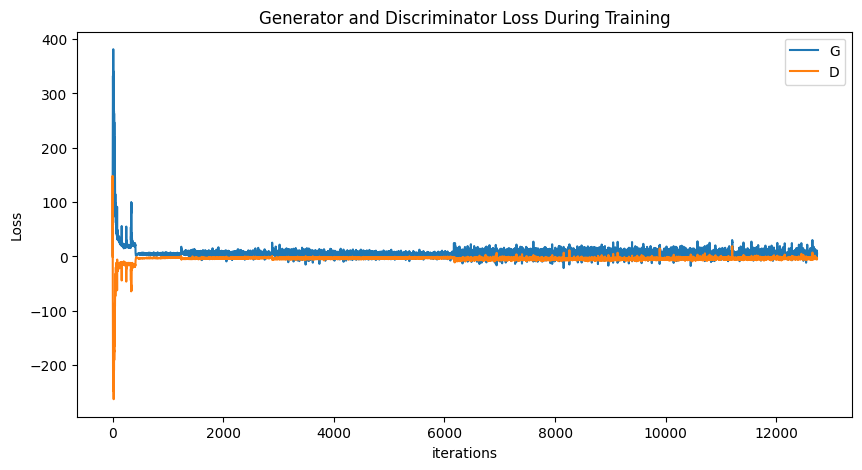

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters and global variables
dataset_dir = "/kaggle/input/mnistasjpg/trainingSet/trainingSet"
start_train_img_size = 4
lr = 1e-3
batch_sizes = [512,256,128,64,32]
channels_img = 3
z_dim = 512
w_dim = 512
in_channels = 512
lambda_gp = 10
progressive_epochs = [5] * len(batch_sizes)
gen_save_path = "/kaggle/working/stylegan_gen.pth"
disc_save_path = "/kaggle/working/stylegan_disc.pth"
training_plot_save_path = "/kaggle/working/train_plot.png"
animation_save_path = "/kaggle/working/animation.mp4"

# check_loader() 

# Define models and optimizers
gen_net = Generator(z_dim, w_dim, in_channels, channels_img).to(device)
disc_net = Discriminator(in_channels, channels_img).to(device)
gen_optimizer = optim.Adam([{"params": [param for name, param in gen_net.named_parameters() if "map" not in name]},
                     {"params": gen_net.map.parameters(), "lr": 1e-5}], lr=lr, betas=(0.0, 0.99))
disc_optimizer = optim.Adam(disc_net.parameters(), lr=lr, betas=(0.0, 0.99))

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

# Monitor Progress
progress = list()
fixed_noise = torch.randn(100, z_dim, device=device)
fixed_labels = []
for i in range(10):
    lab = [0 if j != i else 1 for j in range(10)]
    lab = lab*10
    fixed_labels.append(lab)
fixed_labels = torch.Tensor(fixed_labels).view(100, 10).float().to(device)

# Training loop
gen_net.train()
disc_net.train()
step = int(math.log2(start_train_img_size / 4))
for num_epochs in progressive_epochs[step:]:
    alpha = 1e-7
    
    loader, dataset = get_loader(4*2**step)
    print("Curent image size: " + str(4*2**step))

    for epoch in range(num_epochs):
        # print(f"Epoch [{epoch + 1}/{num_epochs}")

        loop = tqdm(loader, leave=True)

        for batch_idx, (real_images, labels) in enumerate(loop):
            real_images = real_images.to(device)
            current_batch_size = real_images.shape[0]
            noise = torch.randn(current_batch_size, z_dim).to(device)
            labels = labels.to(device).to(torch.float32)
#             print(labels.dtype)
#             print(real_images.shape, labels.shape)
            
            fake = gen_net(noise, labels, alpha, step)
            real_output = disc_net(real_images, labels, alpha, step)
            fake_output = disc_net(fake.detach(), labels, alpha, step)

            grad_penalty = gradient_penalty(disc_net, labels, real_images, fake, alpha, step, device)
            disc_loss = (-(torch.mean(real_output)-torch.mean(fake_output)) + lambda_gp*grad_penalty + (0.001)*torch.mean(real_output**2))

            disc_net.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

            gen_fake = disc_net(fake, labels, alpha, step)
            gen_loss = -torch.mean(gen_fake)

            gen_net.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            alpha += current_batch_size/(progressive_epochs[step]*0.5*len(dataset))
            alpha = min(alpha,1)

            loop.set_postfix(grad_penalty = grad_penalty.item(), disc_loss = disc_loss.item())
        
            # Training Update
            if batch_idx % 50 == 0:
                print(f"[{epoch}/{num_epochs}][{batch_idx}/{len(loader)}]\tLoss_D: {disc_loss.item()}\tLoss_G: {gen_loss.item()}")

            # Tracking loss
            G_losses.append(gen_loss.item())
            D_losses.append(disc_loss.item())

            # Tracking Generator Progress
            if (iters%50 == 0) or ((epoch == num_epochs-1) and (batch_idx == len(loader)-1)):
                with torch.no_grad():
                    fake = gen_net(fixed_noise, fixed_labels, alpha, step).detach().cpu()
                progress.append(torch_utils.make_grid(fake, padding=2, nrow=10, normalize=True))

            iters += 1

#     generate_examples(gen_net, step)
    step += 1

# Save generator
torch.save(gen_net, gen_save_path)
torch.save(disc_net, disc_save_path)

# Plot Training Graph
fig1 = plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(training_plot_save_path)
plt.show()

# Progress Animation
fig2 = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in progress]
anim = animation.ArtistAnimation(fig2, ims, interval=1000, repeat_delay=1000, blit=True)
writervideo = animation.FFMpegWriter(fps=5)
anim.save(animation_save_path, writer=writervideo)
plt.close()